In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import cv2

In [32]:
import os
import shutil
import librosa
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from joblib import Parallel, delayed

### Config

In [52]:
# Input folder
train_dir = Path('E:\data\BirdCLEF')
train_csv = train_dir / 'train_metadata.csv'

In [35]:
class Config():
    # Horizontal melspectrogram resolution
    MELSPEC_H = 128
    # Competition Root Folder
    ROOT_FOLDER = train_dir
    AUDIO_FOLDER = train_dir / 'train_audio'
    OUTPUT_DIR = train_dir / 'spectros'
    # Maximum decibel to clip audio to
    TOP_DB = 100
    # Minimum rating
    MIN_RATING = 3.0
    # Sample rate as provided in competition description
    SR = 32000
    N_FFT = 2048
    HOP_LENGTH = 512
    
CONFIG = Config()

In [54]:
meta_df = pd.read_csv(train_csv)
meta_df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg


In [36]:
sample_submission = pd.read_csv(train_dir / 'sample_submission.csv')

# Set labels
CONFIG.LABELS = sample_submission.columns[1:]
CONFIG.N_LABELS = len(CONFIG.LABELS)
print(f'# labels: {CONFIG.N_LABELS}')

display(sample_submission.head())

# labels: 182


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [51]:
# Maps a class to corresponding integer label
CLASS2LABEL = dict(zip(CONFIG.LABELS, np.arange(CONFIG.N_LABELS)))
# Label to class mapping
LABEL2CLASS = dict([(v,k) for k, v in CLASS2LABEL.items()])

In [37]:
CONFIG.LABELS

Index(['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1',
       'aspfly1', 'aspswi1', 'barfly1', 'barswa',
       ...
       'whbwoo2', 'whcbar1', 'whiter2', 'whrmun', 'whtkin2', 'woosan',
       'wynlau1', 'yebbab1', 'yebbul3', 'zitcis1'],
      dtype='object', length=182)

### Preprocess scripts

In [46]:
# A function for processing a single audio file and saving it
def ogg2npy(file_path, destination, sr=32000):
    # Audio loading
    y, sr = librosa.load(file_path, sr=sr)
    
    # Create Mel-Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)

    # Path to save
    npy_file_path = os.path.join(destination, f'{os.path.splitext(os.path.basename(file_path))[0]}.npy')

    # Save as NPY
    np.save(npy_file_path, log_mel_spectrogram)

def ogg2npy_parallel(files, destination):
    # Parallel using joblib and a progress bar using tqdm
    result = Parallel(n_jobs=8)(
        delayed(ogg2npy)
        (file, destination) 
        for file in tqdm(files)
    )

In [64]:
# https://www.kaggle.com/code/markwijkhuizen/birdclef-2024-eda-preprocessed-dataset/notebook
def ogg2png(file_name, source=Config.AUDIO_FOLDER):
    file_path = source / file_name
    
    # Load the audio file
    y, _ = librosa.load(file_path, sr=CONFIG.SR)
    # Normalize audio
    y = librosa.util.normalize(y)
    # Convert to mel spectrogram
    spec = librosa.feature.melspectrogram(
        y=y,
        sr=CONFIG.SR, # sample rate
        n_fft=CONFIG.N_FFT, # number of samples in window 
        hop_length=CONFIG.HOP_LENGTH, # step size of window
        n_mels=CONFIG.MELSPEC_H, # horizontal resolution from fmin→fmax in log scale
        fmin=40, # minimum frequency
        fmax=15000, # maximum frequency
        power=2.0, # intensity^power for log scale
    )
    # Convert to Db
    spec = librosa.power_to_db(spec, ref=CONFIG.TOP_DB)
    # Normalize 0-min
    spec = spec - spec.min()
    # Normalize 0-255
    spec = (spec / spec.max() * 255).astype(np.uint8)
    # Convert to PNG bytes
    _, spec_png_uint8 = cv2.imencode('.png', spec)
    spec_png_bytes = bytes(spec_png_uint8)
    
    return file_name, spec_png_bytes

In [78]:
def ogg2png_parallel(df):
    files = df['filename'].tolist()

    labels = df[['filename', 'primary_label']]

    # Create dataset
    X = {}
    y = {}

    for idx, row in meta_df[['filename', 'primary_label']].iterrows():
        key = row['filename']
        y[key] = CLASS2LABEL.get(row['primary_label'])
    
    # Parallel using joblib and a progress bar using tqdm
    results = Parallel(n_jobs=8)(
        delayed(ogg2png)
        (file) 
        for file in tqdm(files)
    )

    for item in results:
        X[item[0]] = item[1]

    return X, y

### Preprocess

In [85]:
files = [item for item in Config.AUDIO_FOLDER.rglob('*.ogg') ]
len(files)

24459

In [86]:
%%time

# ogg2npy_parallel(files, Config.OUTPUT_DIR) # TOO LARGE
# create_spectros(files, ogg2png, output_folder)

CPU times: total: 0 ns
Wall time: 0 ns


In [87]:
%%time
X, y = ogg2png_parallel(meta_df)



  0%|                                                                                 | 0/24459 [00:00<?, ?it/s]

  0%|▏                                                                      | 48/24459 [00:00<02:22, 171.34it/s]

  0%|▏                                                                      | 80/24459 [00:00<02:11, 185.74it/s]

  0%|▎                                                                     | 112/24459 [00:00<02:27, 164.75it/s]

  1%|▍                                                                     | 144/24459 [00:01<03:09, 128.50it/s]

  1%|▌                                                                     | 176/24459 [00:01<03:13, 125.46it/s]

  1%|▌                                                                     | 208/24459 [00:01<03:41, 109.42it/s]

  1%|▋                                                                      | 240/24459 [00:02<04:07, 97.89it/s]

  1%|▊                                                                      | 272/2445

### Test

In [24]:
import imageio.v3 as imageio

In [99]:
# Example Plots
def example_plots(X, y, N):
    np.random.seed(42)
    random_keys = np.random.choice(list(X.keys()), N)
    
    for k in random_keys:
        spec = imageio.imread(X[k])
        plt.figure(figsize=(12,5))
        plt.title(
                f'Label: {y[k]}, Class: {LABEL2CLASS[y[k]]}, shape: {spec.shape} '
            )
        # plt.imshow(spec)
        librosa.display.specshow(spec, y_axis="mel")
        plt.show()

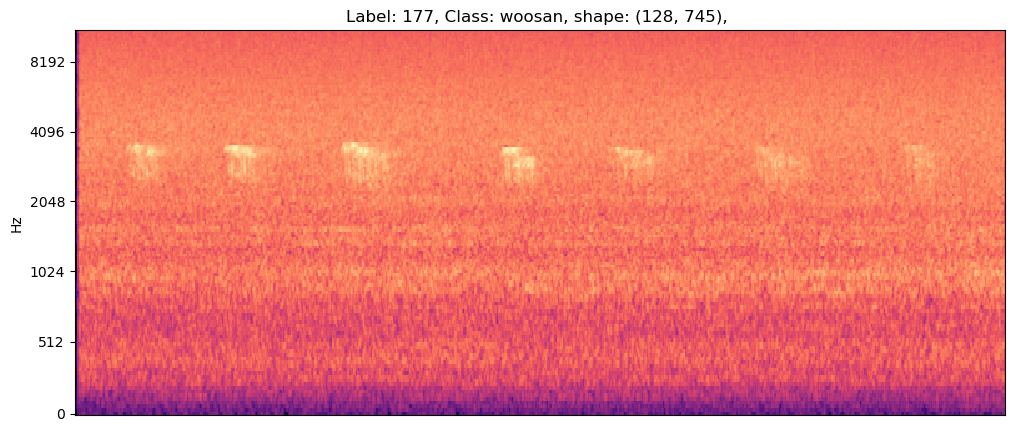

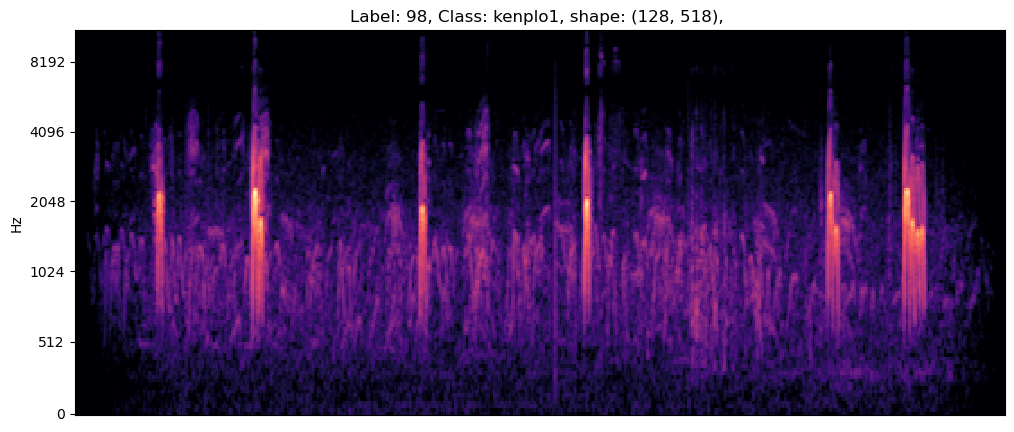

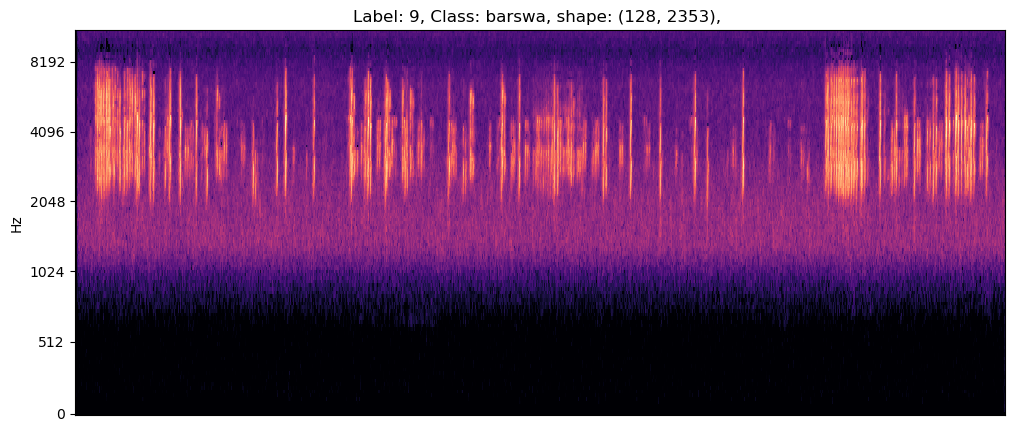

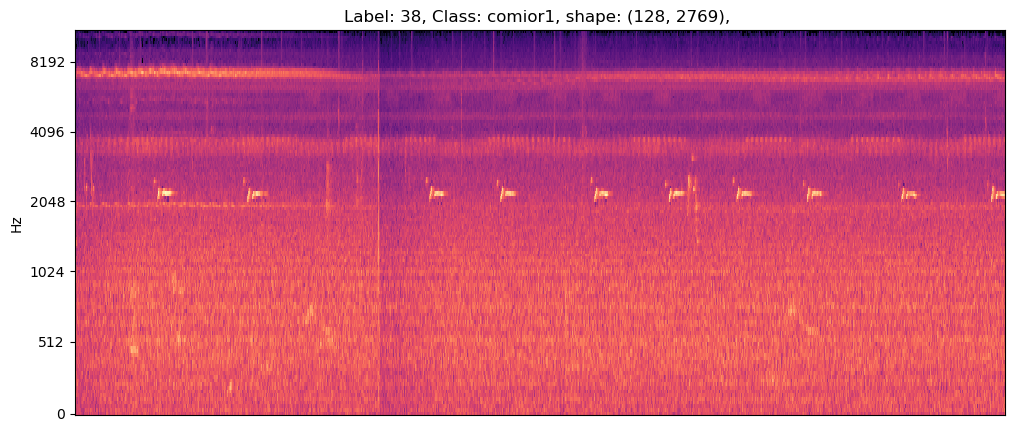

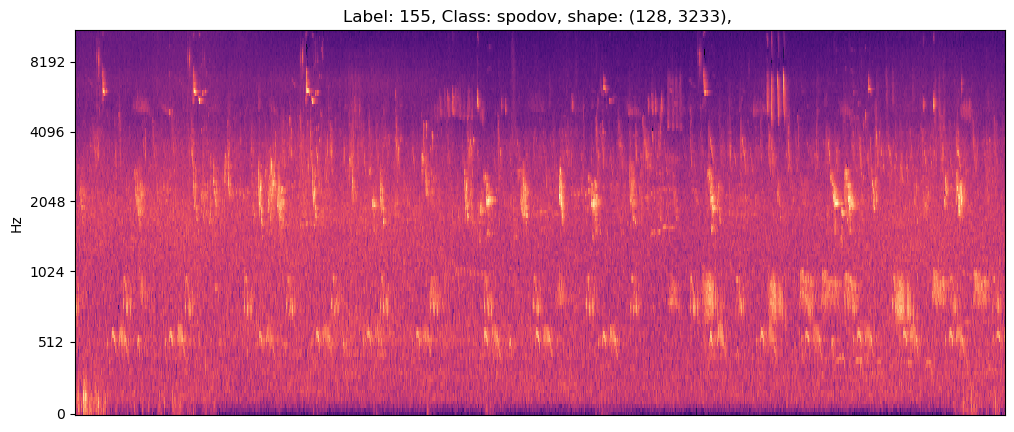

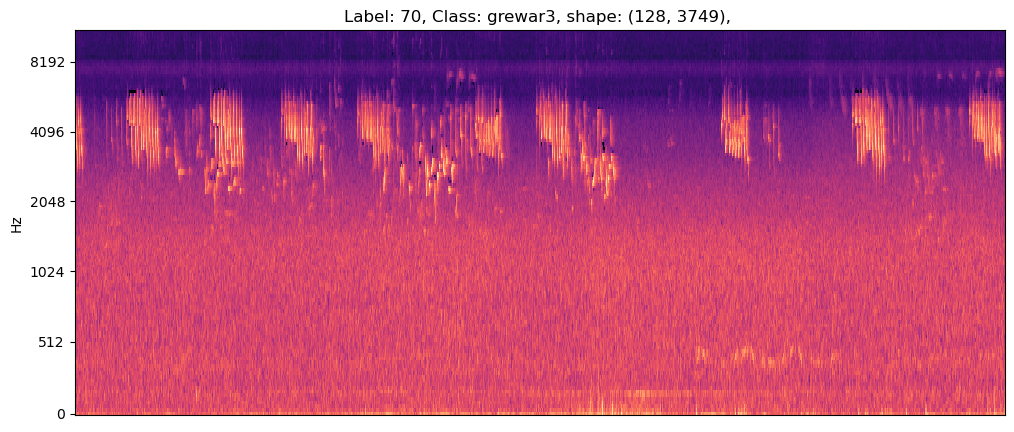

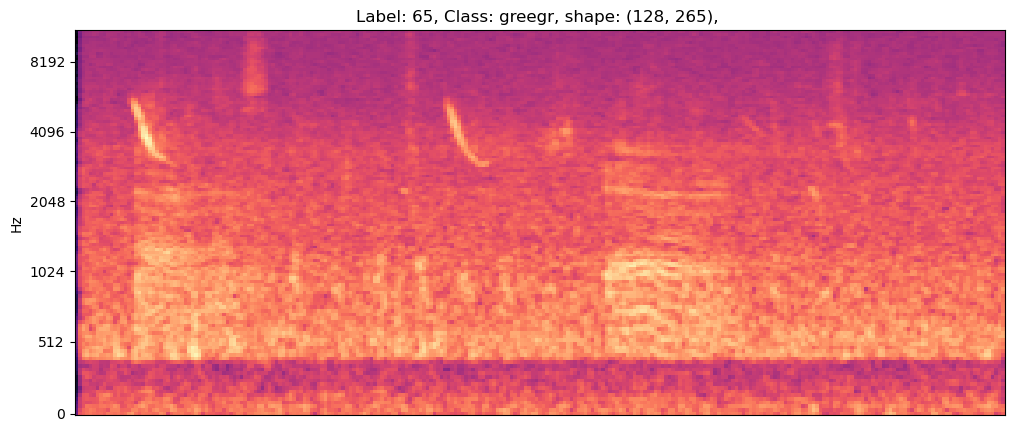

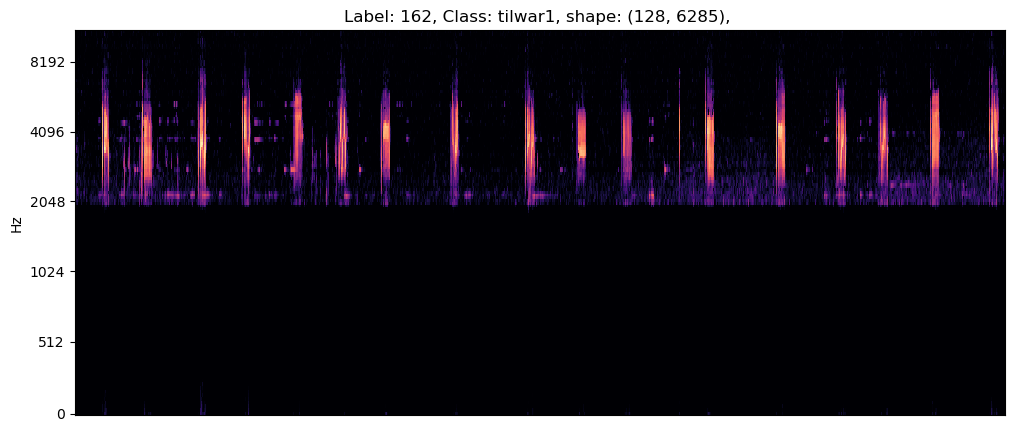

In [100]:
example_plots(X, y, 8)

### Save data

In [91]:
import pickle

In [93]:
# Write X
with open(Config.OUTPUT_DIR / 'X.pkl', 'wb') as f:
    pickle.dump(X, f)
    
# Write y
with open(Config.OUTPUT_DIR / 'y.pkl', 'wb') as f:
    pickle.dump(y, f)